## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Урок 3. Generative adversarial networks (GAN): генеративные сети

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [23]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from torchvision.utils import save_image, make_grid

In [24]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [25]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


**1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:**
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [26]:
# Функция linspace() возвращает одномерный массив из указанного количества элементов, значения которых равномерно распределенны внутри заданного интервала.
x = np.linspace(-10, 10, 1001)

In [27]:
if 0 in x:
    print("В массиве есть 0")

В массиве есть 0


In [28]:
def func_y(x):    
    if 0 in x:
        x[x == 0] = 0.00001
    return np.sin(x)/x - x/10 

In [29]:
y = func_y(x)

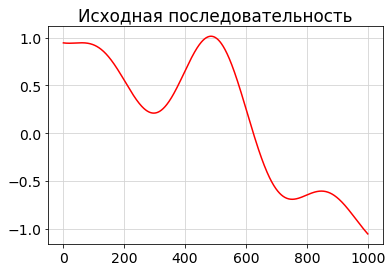

In [30]:
plt.plot(y, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

In [31]:
class Inc_Dataset(Dataset):
    def __init__(self, b_border, u_border, point_number):
        x = np.linspace(b_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [32]:
dataset = Inc_Dataset(-10, 10, 1001)

In [33]:
split_train_part = 0.75
batch_size = 16

real_data_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
real_data_loader = DataLoader(real_data_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

### Генератор

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        # self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sph = nn.Softplus()

    def forward(self, x):
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc1(x))
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc2(x))
        # x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        # print("X размеры in: %s\n" % (x.shape,))
        return x

### Дискриминатор 

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        # self.sfm = nn.Softmax()

    def forward(self, x):
        # print("X размеры d in: %s\n" % (x.shape,))
        x = self.relu(self.fc1(x))
        # print("X размеры fc1 sigm in: %s\n" % (x.shape,))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

### Инициализация

In [36]:
n_epochs = 1000
lr = 0.0001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [37]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [38]:
d_loss_history = []
g_loss_history = []

In [39]:
idx = torch.randperm(16)
idx

tensor([ 7, 11,  8,  9,  5, 12,  3,  1,  4,  6,  0, 15,  2, 10, 14, 13])

In [40]:
for epoch in range(1):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([ 6.9200, -1.7800,  4.6000, -5.0400, -0.6600, -6.4400, -1.0800, -5.6000,
         6.2200, -1.3400, -6.8800, -8.2800,  2.6800, -5.1200,  3.4200, -0.7400])
z: tensor([[-5.1200],
        [ 3.4200],
        [ 6.2200],
        [ 4.6000],
        [-5.0400],
        [-1.0800],
        [-6.8800],
        [-1.3400],
        [-5.6000],
        [ 6.9200],
        [-1.7800],
        [ 2.6800],
        [-8.2800],
        [-0.6600],
        [-0.7400],
        [-6.4400]])
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.697203] [G loss: 0.697973]


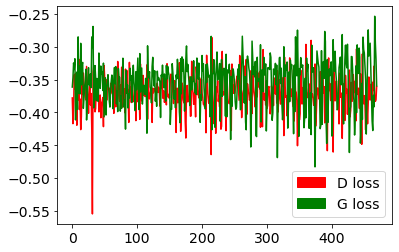

In [41]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(real_data_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [42]:
torch.save(generator.state_dict(), "series_gan.pth")

In [43]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [44]:
x =  np.linspace(-10, 10, 50)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.FloatTensor'

In [45]:
gen_numbers = generator_r(xt.view(len(x), 1))

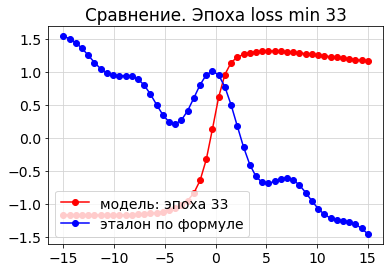

In [46]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {ep_loss}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Сравнение. Эпоха loss min {ep_loss}' )
plt.show()

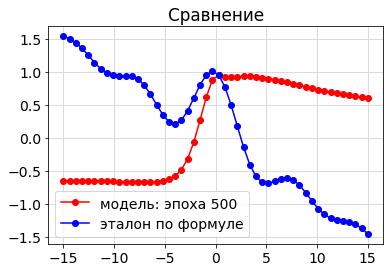

In [47]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {n_epochs}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

### Тестовый dataset


In [48]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [49]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

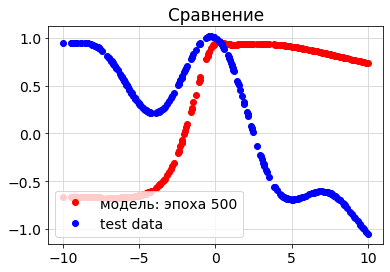

In [50]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"модель: эпоха {n_epochs}")
plt.plot(x_test, y_test, 'bo', label=f"test data")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

**2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.**

In [58]:
import torchvision
import torchvision.transforms as transforms

In [78]:
import urllib

basepath = ''


def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                         'Chrome/80.0.3987.132 Safari/537.36',)
    opener.retrieve(
    url, f'{basepath}/{filename}')

set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', '.\MNIST\raw\train-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

<ipython-input-78-eb25649d119c>:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', '.\MNIST\raw\train-images-idx3-ubyte.gz')


OSError: [Errno 22] Invalid argument: '/.\\MNIST\raw\train-images-idx3-ubyte.gz'

In [72]:
batch_size = 32
img_size = 28

transforms.ToTensor() преобразует данные в тензор PyTorch.
transforms.Normalize() преобразует диапазон тензорных коэффициентов.
Исходные коэффициенты, заданные функцией transforms.ToTensor(), находятся в диапазоне от 0 до 1. Поскольку изображения имеют черный фон, большинство коэффициентов равны 0.
Функция transforms.Normalize() изменяет диапазон коэффициентов на [−1,1][−1,1], вычитая 0.5 из исходных коэффициентов и деля результат на 0.5. Преобразование сокращает количество элементов входных выборок, равных 0. Это помогает в обучении моделей.

In [73]:
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         ".",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=batch_size,
#     shuffle=True,
# )

In [74]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform)

0it [00:00, ?it/s]

HTTPError: HTTP Error 403: Forbidden

In [75]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

NameError: name 'train_set' is not defined